In [32]:
# ------------------------------------------
# Script: 3 (Network_properties.ipynb)
# ------------------------------------------
# Author: Pratyay Sengupta
# ------------------------------------------

In [33]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_venn import venn3

# Set data directories
input_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/network_files/'
output_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/'
figures_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Figures/'

# Create output subfolders if not exist
os.makedirs(os.path.join(output_dir, "network_files"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "edges_classification"), exist_ok=True)

In [34]:
# --------------------------------------------------------
# Load edges and nodes for each environment
# --------------------------------------------------------
environments = ["Hospital", "Metro", "Office"]
edges = {}
nodes = {}

for env in environments:
    edge_file = os.path.join(input_dir, f"{env}_edges.tsv")
    net_edges = pd.read_csv(edge_file, sep=",")
    
    # Sort node pairs to maintain consistency
    sorted_edges = pd.DataFrame({
        'v1': np.minimum(net_edges['v1'], net_edges['v2']),
        'v2': np.maximum(net_edges['v1'], net_edges['v2']),
        'Weight': net_edges['Weight']
    })
    
    edges[env] = sorted_edges
    nodes[env] = set(sorted_edges['v1']).union(sorted_edges['v2'])

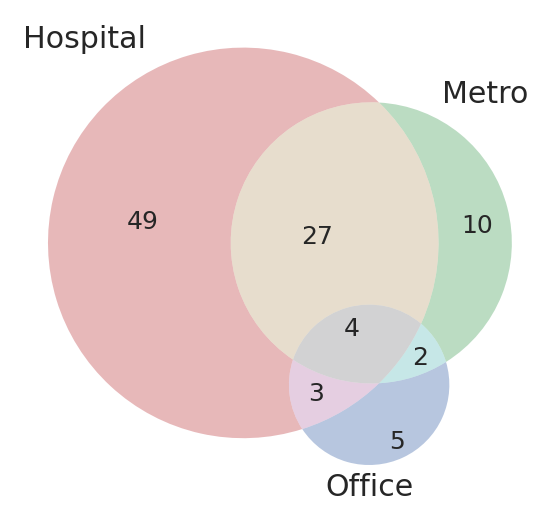

In [35]:
# Plot Venn Diagram of Nodes

plt.figure(figsize=(6, 6))
venn3([nodes["Hospital"], nodes["Metro"], nodes["Office"]],
      set_labels=("Hospital", "Metro", "Office"))
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'Figure_4A_1.svg'), dpi=300)
plt.show()

# Create Presence/Absence Matrix for Nodes
all_nodes = sorted(set.union(*nodes.values()))
presence_absence = pd.DataFrame(index=all_nodes)

for env in environments:
    presence_absence[env] = presence_absence.index.isin(nodes[env]).astype(int)

# Save presence/absence matrix
presence_absence.to_csv(os.path.join(output_dir, "network_files/Presence_absence_nodes.tsv"), sep="\t")

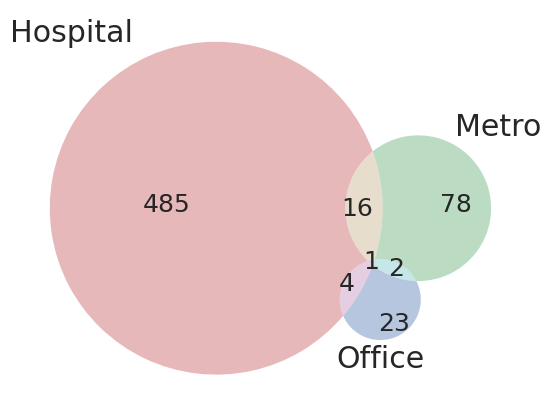

In [36]:
# Plot Venn Diagram of Edges

interactions = {
    env: set(zip(edges[env]['v1'], edges[env]['v2']))
    for env in environments
}

plt.figure(figsize=(6, 6))
venn3([interactions["Hospital"], interactions["Metro"], interactions["Office"]],
      set_labels=("Hospital", "Metro", "Office"))
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'Figure_4A_2.svg'), format='svg')
plt.show()

In [37]:
# Find common edges shared across all environments
shared_interactions = interactions["Hospital"].intersection(interactions["Metro"], interactions["Office"])

shared_interactions

{('Brevibacterium casei', 'Enhydrobacter aerosaccus')}

In [38]:
# --------------------------------------------------------
# Prepare Edge Presence/Absence Matrix
# --------------------------------------------------------
all_interactions = set.union(*interactions.values())

edge_presence = {
    env: {edge: 1 if edge in interactions[env] else 0 for edge in all_interactions}
    for env in environments
}

edges_df = pd.DataFrame(edge_presence).sort_index()
edges_df.to_csv(os.path.join(input_dir, "Presence_absence_edges.tsv"), sep="\t")

In [39]:
# --------------------------------------------------------
# Load Organism List per Environment
# --------------------------------------------------------
source_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/phyloseq_source/'
organisms = {}

for env in environments:
    org_data = pd.read_csv(os.path.join(source_dir, f"{env}_filtered_data.csv"), sep=",")
    organisms[env] = org_data["Species"].tolist()

# Load Taxa Binary Data
taxa_binary = pd.read_csv(os.path.join(output_dir, "1_taxa_binary.csv"), sep=",", index_col=0)

In [40]:
# --------------------------------------------------------
# Edge Classification: Generalized vs Specialized
# --------------------------------------------------------
edge_classification_summary = []

for env in environments:
    ge, se0, se1, se2 = 0, 0, 0, 0
    
    for _, row in edges[env].iterrows():
        edge = (row["v1"], row["v2"])
        
        if edge in edges_df.index:
            match = edges_df.loc[edge]
            if match.sum() > 1:
                ge += 1
            else:
                involved_species = [row["v1"], row["v2"]]
                species_profiles = taxa_binary.loc[taxa_binary.index.isin(involved_species)].sum(axis=1).tolist()
                if tuple(species_profiles) == (1, 1):
                    se0 += 1
                elif any((a == 1 and b > 1) or (a > 1 and b == 1) for a, b in [species_profiles]):
                    se1 += 1
                elif any((a > 1 and b > 1) for a, b in [species_profiles]):
                    se2 += 1
                    
    edge_classification_summary.append([env, ge, se0, se1, se2])

edge_details = pd.DataFrame(edge_classification_summary, columns=["Environment", "Generalized", "Specialized_Both_Unique", "Specialized_One_Unique", "Specialized_Both_Generalized"])
edge_details.set_index("Environment", inplace=True)

edge_details


,Generalized,Specialized_Both_Unique,Specialized_One_Unique,Specialized_Both_Generalized
Environment,,,,
Hospital,21,95,228,162
Metro,19,10,37,31
Office,7,2,18,3


In [41]:
# --------------------------------------------------------
# Normalize Edge Details Row-Wise (Convert to Percentages)
# --------------------------------------------------------

def normalize_row_wise(row):
    """Normalize the row values as percentages."""
    total = row.sum()
    return row.apply(lambda x: (x / total) * 100 if total != 0 else 0)

edge_details_per = edge_details.apply(normalize_row_wise, axis=1)

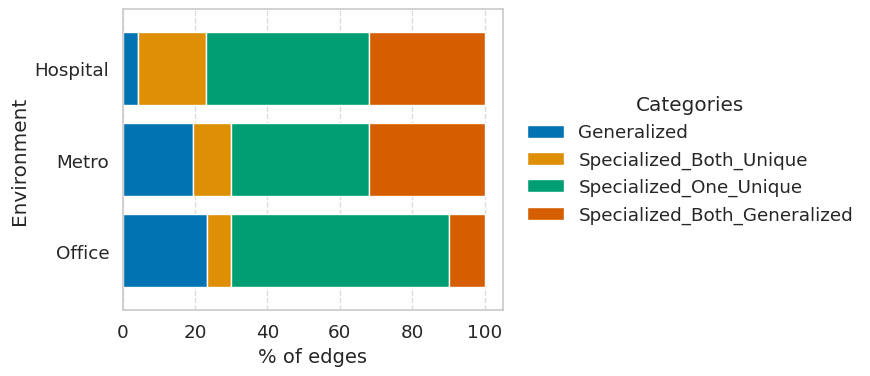

In [42]:
# --------------------------------------------------------
# Horizontal Bar Plot of Edge Classifications
# --------------------------------------------------------

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.2, palette="colorblind")

# Prepare the figure
fig, ax = plt.subplots(figsize=(9, 4))  # Wide but compact

# Plot
edge_details_per[::-1].plot(
    kind='barh',
    stacked=True,
    width=0.8,
    ax=ax
)

# Titles and labels
ax.set_xlabel('% of edges', fontsize=14)

# Ticks and grid
ax.xaxis.set_tick_params(rotation=0)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.grid(axis='y', visible=False)

# Legend
ax.legend(
    title='Categories',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

# Final layout adjustments
plt.tight_layout()
plt.savefig(figures_dir + 'Figure_4C.svg', format='svg', bbox_inches='tight')
plt.show()

In [43]:
# --------------------------------------------------------
# Function to Classify Each Edge
# --------------------------------------------------------
def classify_edge(row, edge_matrix, taxa_matrix):
    edge = (row["v1"], row["v2"])
    if edge in edge_matrix.index:
        match = edge_matrix.loc[edge]
        if match.sum() > 1:
            return "Generalized"
        else:
            involved = [row["v1"], row["v2"]]
            sums = taxa_matrix.loc[taxa_matrix.index.isin(involved)].sum(axis=1).tolist()
            if tuple(sums) == (1, 1):
                return "Specialized_One_Unique"
            elif any((a == 1 and b > 1) or (a > 1 and b == 1) for a, b in [sums]):
                return "Specialized_Both_Unique"
            elif any((a > 1 and b > 1) for a, b in [sums]):
                return "Specialized_Shared_Edge"
    return None

In [44]:
# --------------------------------------------------------
# Apply Classification to All Edges
# --------------------------------------------------------
classified_edges = {}

for env, df in edges.items():
    df = df.copy()
    df["classification"] = df.apply(lambda row: classify_edge(row, edges_df, taxa_binary), axis=1)
    classified_edges[env] = df

# Merge all classified edges
merged_edges = pd.concat(classified_edges.values(), ignore_index=True)

In [45]:
# --------------------------------------------------------
# Map Taxonomy Information
# --------------------------------------------------------
taxa_data = pd.read_csv(os.path.join(output_dir, "phyloseq_source/all_filtered_taxa.csv"), sep=",")
species_to_class = taxa_data.set_index('species')['class'].to_dict()

merged_edges['v1_class'] = merged_edges['v1'].map(species_to_class)
merged_edges['v2_class'] = merged_edges['v2'].map(species_to_class)

In [46]:
# --------------------------------------------------------
# Save Edge Classifications
# --------------------------------------------------------
pair_counts = (
    merged_edges.groupby(['classification', 'v1_class', 'v2_class'])
    .size()
    .reset_index(name='count')
)

pair_counts.to_csv(os.path.join(input_dir, "edges_classification/edges_classification.csv"), sep="\t", index=False)

# Save pivoted versions per classification
for classification, df_group in pair_counts.groupby('classification'):
    all_classes = pd.unique(df_group[['v1_class', 'v2_class']].values.ravel())
    pivot_table = (
        df_group
        .pivot_table(index='v1_class', columns='v2_class', values='count', aggfunc='sum', fill_value=0)
        .reindex(index=all_classes, columns=all_classes, fill_value=0)
    )
    pivot_table.to_csv(os.path.join(input_dir, f"edges_classification/{classification}_edges.csv"), sep="\t")

In [47]:
# --------------------------------------------------------
# Map Genus-Level Edges to Class-Level
# --------------------------------------------------------

# Extract genus-level edges
genus_edge = {
    environment: edges[environment][['v1', 'v2']].apply(lambda x: x.str.split().str[0])
    for environment in environments
}

# Load taxonomy info
taxa_data = pd.read_csv(output_dir + "phyloseq_source/all_filtered_taxa.csv", sep=",")

# Map genus to class
genus_to_class = taxa_data.set_index('genus')['class'].to_dict()
for environment in environments:
    genus_edge[environment]['v1'] = genus_edge[environment]['v1'].map(genus_to_class)
    genus_edge[environment]['v2'] = genus_edge[environment]['v2'].map(genus_to_class)

In [48]:
# --------------------------------------------------------
# Create Class-Class Interaction Matrices
# --------------------------------------------------------

matrices = {}

for environment, df in genus_edge.items():
    unique_elements = sorted(set(df['v1'].astype(str)).union(df['v2'].astype(str)))
    matrix = pd.DataFrame(0, index=unique_elements, columns=unique_elements)

    for _, row in df.iterrows():
        v1, v2 = str(row['v1']), str(row['v2'])
        matrix.loc[v1, v2] += 1
        matrix.loc[v2, v1] += 1

    # Keep only lower triangle
    lower_tri = np.tril(matrix)
    lower_tri_df = pd.DataFrame(lower_tri, index=unique_elements, columns=unique_elements).fillna(0)

    matrices[environment] = lower_tri_df

    # Clean NaNs if any
    if 'nan' in lower_tri_df.columns:
        matrices[environment].drop(index=['nan'], columns=['nan'], inplace=True)

    # Save
    matrices[environment].to_csv(output_dir + f"network_files/class_interactions/{environment}_class_matrix.csv", sep="\t")

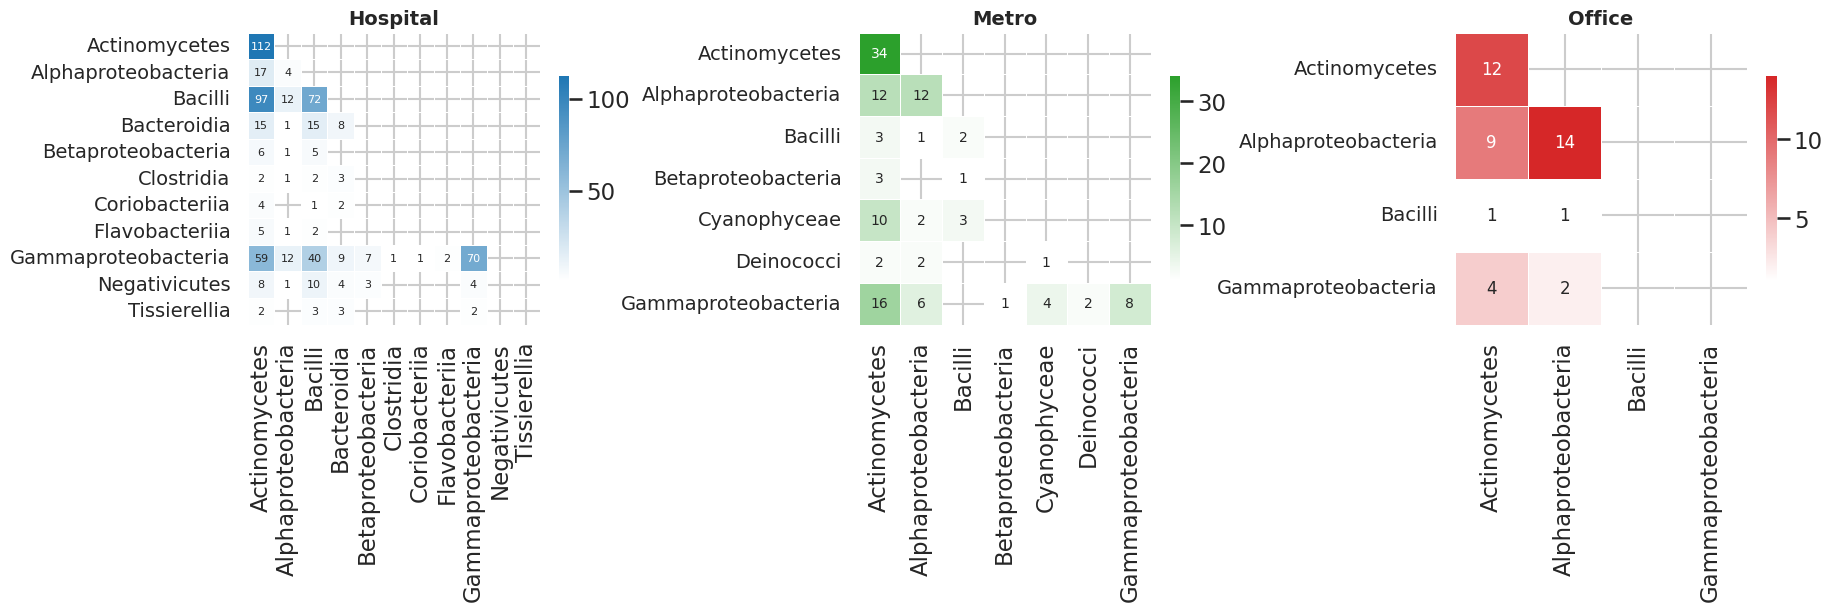

In [49]:
# --------------------------------------------------------
# Plot Heatmaps of Class-Level Interactions
# --------------------------------------------------------

# Create custom colormap
def create_custom_cmap(color):
    return LinearSegmentedColormap.from_list('custom_cmap', ['white', color])

# Updated colors: blue, green, red
colors = ['#1f77b4', '#2ca02c', '#d62728']

sns.set_context("talk")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for (ax, (env, df), color) in zip(axes, matrices.items(), colors):
    cmap = create_custom_cmap(color)
    mask = df == 0

    # Determine dynamic font size: based on number of rows
    n_rows = df.shape[0]
    if n_rows <= 5:
        annot_font_size = 12
    elif n_rows <= 10:
        annot_font_size = 10
    else:
        annot_font_size = 8

    sns.heatmap(
        df,
        mask=mask,
        cmap=cmap,
        ax=ax,
        cbar=True,
        linewidths=0.5,
        square=True,
        annot=True,
        fmt='d',
        annot_kws={"size": annot_font_size},
        cbar_kws={'shrink': 0.7}
    )

    ax.set_title(env, fontsize=14, fontweight='bold')
    ax.tick_params(axis='y', rotation=0, labelsize=14)  

plt.savefig(figures_dir + 'Figure_4D.svg', format='svg', bbox_inches='tight')
plt.show()

In [50]:
# --------------------------------------------------------
# Process Hub Files (Load, Merge, Save)
# --------------------------------------------------------

hub_path = input_dir + "hub_files/"
hub_dict = {}

for env in environments:
    temp_df = pd.read_csv(hub_path + env + "_hubs.tsv", sep=",")
    unique_orgs = np.unique(temp_df.iloc[:, ::2].values.flatten())

    hub_info = [
        {
            'degree1': temp_df[temp_df['Organism'] == org]['degree1'].values[0] if org in temp_df['Organism'].values else 0,
            'close1': temp_df[temp_df['Organism.1'] == org]['close1'].values[0] if org in temp_df['Organism.1'].values else 0,
            'eigenv1': temp_df[temp_df['Organism.2'] == org]['eigenv1'].values[0] if org in temp_df['Organism.2'].values else 0
        }
        for org in unique_orgs
    ]

    ind_hub_df = pd.DataFrame(hub_info, index=unique_orgs)
    ind_hub_df = ind_hub_df[ind_hub_df.sum(axis=1) != 0]
    ind_hub_df.columns = [env + '_Degree', env + '_Closeness', env + '_Eigenvector']
    ind_hub_df = ind_hub_df.round(2)

    hub_dict[env] = ind_hub_df
    ind_hub_df.to_csv(output_dir + f"network_files/hub_files/{env}_hubs_v2.tsv", sep="\t")

# Merge all hub files
hub_merged = pd.concat(hub_dict.values(), axis=1)
hub_merged.fillna(0, inplace=True)
hub_merged.sort_index(inplace=True)
hub_merged.to_csv(output_dir + "network_files/hub_files/hub_merged.tsv", sep="\t")


In [51]:
# --------------------------------------------------------
# Map Hub Nodes to Genome Info
# --------------------------------------------------------

genome_info = pd.read_csv(output_dir + '2_genome_details.csv', sep=',', index_col="organism_name")
genome_info = genome_info[["assembly_accession"]]

matching_indexes = [idx for idx in genome_info.index if any(hub in idx for hub in hub_merged.index)]
genome_info = genome_info.loc[matching_indexes]
genome_info.to_csv(output_dir + "network_files/hub_files/genome_info_hubs.tsv", sep="\t")

In [52]:
# --------------------------------------------------------
# Abundance Captured by Hubs
# --------------------------------------------------------

abundance_path = output_dir + "phyloseq_source/all_filtered_data.csv"
metadata_path = output_dir + "phyloseq_source/all_filtered_metadata.csv"

abundance_data = pd.read_csv(abundance_path, sep=",", index_col="Species")
metadata = pd.read_csv(metadata_path, sep=",", index_col="Illumina Library ID")

hub_abundance = {}

for env in environments:
    nodes = list(hub_merged.index)
    ids = list(metadata[metadata['Environment'] == env].index)
    abundance = abundance_data.loc[nodes, ids]
    hub_abundance[env] = list(abundance.mean(axis=1))

hub_abundance_df = pd.DataFrame(hub_abundance, index=nodes)
hub_abundance_df *= 100000
hub_abundance_df[hub_abundance_df != 0] = np.log2(hub_abundance_df[hub_abundance_df != 0])
hub_abundance_df = hub_abundance_df.round(3)
hub_abundance_df.to_csv(output_dir + "network_files/hub_files/hub_abundance.tsv", sep="\t")

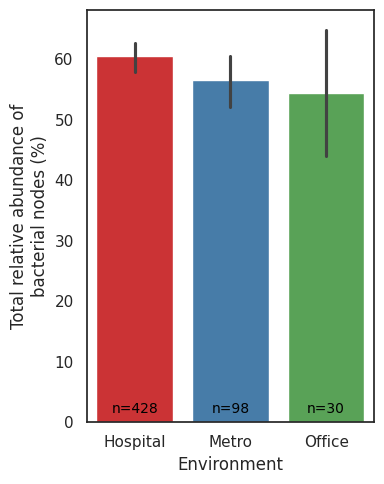

In [53]:
captured_abundance = {}

sns.set(style="white")

for env in environments:
    nodes = list(pd.concat([edges[env]['v1'], edges[env]['v2']]).unique())
    ids = list(metadata[metadata['Environment'] == env].index)
    abundance = abundance_data.loc[nodes, ids]
    captured_abundance[env] = list(abundance.sum(axis=0))

# Convert to DataFrame
combined_data = pd.concat({k: pd.Series(v) for k, v in captured_abundance.items()}).reset_index()
combined_data.columns = ['Environment', 'Index', 'Abundance']

# Convert to percentage
combined_data['Abundance'] *= 100

# Set environment order
env_order = sorted(combined_data['Environment'].unique())

plt.figure(figsize=(4, 5))
sns.barplot(
    x='Environment', y='Abundance', data=combined_data,
    order=sorted(env_order), 
    errorbar=("ci", 95), palette='Set1', hue='Environment')

plt.xlabel('Environment')
plt.ylabel('Total relative abundance of\nbacterial nodes (%)')
plt.tight_layout()

# Add sample size (n=) inside each bar
grouped = combined_data.groupby('Environment')
for i, env in enumerate(env_order):
    n_samples = grouped.get_group(env).shape[0]
    plt.text(
        i, 1, f'n={n_samples}',
        ha='center', va='bottom', 
        color='black', fontsize=10
    )

plt.savefig(figures_dir + 'Supplementary_Figure_3A.svg', format='svg')
plt.show()

In [54]:
# --------------------------------------------------------
# Cluster Analysis: Class-Level Diversity per Network Module
# --------------------------------------------------------

# Define environments
environments = ["Hospital", "Metro", "Office"]

# Step 0: Load Cluster Data for Each Environment
cluster_df = {}

for env in environments:
    cluster_data = pd.read_csv(
        output_dir + f"network_files/clusters/{env}_LCC_clusters.csv", 
        sep=",", index_col=0
    )
    cluster_data.index.name = "Organism"
    cluster_df[env] = cluster_data

# Step 1: Load Taxonomic Data
taxa_data = pd.read_csv(
    output_dir + "phyloseq_source/all_filtered_taxa.csv", 
    sep=",", index_col=0
)

# Step 2: Prepare Long-Form Cluster Data
all_clusters = []

for env, df in cluster_df.items():
    for organism, row in df.iterrows():
        cluster_num = row[0]
        cluster_name = f"{env}_{cluster_num}"
        all_clusters.append({"Organism": organism, "Module": cluster_name})

cluster_long_df = pd.DataFrame(all_clusters)

# Step 3: Merge Cluster Data with Class-Level Taxonomy
merged_df = cluster_long_df.merge(
    taxa_data[["class"]], 
    left_on="Organism", 
    right_index=True, 
    how="left"
)
merged_df["class"] = merged_df["class"].fillna("Unknown")

# Step 4: Count Organisms per Module and Class
counts = merged_df.groupby(["Module", "class"]).size().reset_index(name="Count")
pivot_df = counts.pivot(index="Module", columns="class", values="Count").fillna(0)

# Step 5: Identify Top 7 Most Abundant Classes
total_counts = pivot_df.sum().sort_values(ascending=False)
top_classes = total_counts.head(7).index.tolist()

# Step 6: Group Rare Classes into 'Other'
pivot_df["Other"] = pivot_df.drop(columns=top_classes).sum(axis=1)
pivot_df = pivot_df[top_classes + ["Other"]]  # Keep order: Top classes first, then 'Other'

# Step 7: Sort Classes for Plotting
ordered_classes = ["Other"] + sorted(top_classes, reverse=True)
pivot_df = pivot_df[ordered_classes]

# Step 8: Define Color Palette
color_palette = sns.color_palette("tab20", len(top_classes))
colors = ["#d3d3d3"] + list(color_palette[::-1])  # Grey for 'Other' + reverse colors

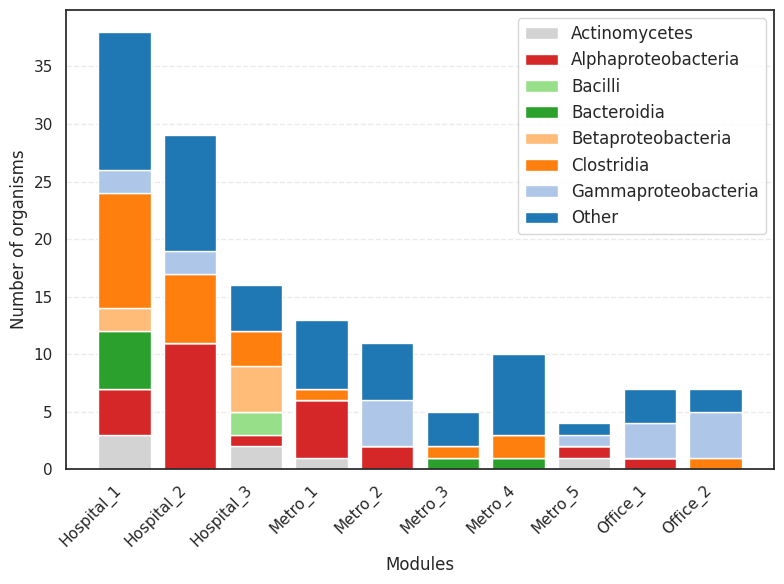

In [55]:
# --------------------------------------------------------
# Plot Stacked Bar Plot: Class Distribution per Module
# --------------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 6))
bottom = None

for i, cls in enumerate(ordered_classes):
    ax.bar(
        pivot_df.index, pivot_df[cls],
        bottom=bottom, color=colors[i],
        label=cls, width=0.8
    )
    if bottom is None:
        bottom = pivot_df[cls].copy()
    else:
        bottom += pivot_df[cls]

# Styling
ax.set_ylabel("Number of organisms")
ax.set_xlabel("Modules")
ax.set_xticks(range(len(pivot_df)))
ax.set_xticklabels(pivot_df.index, rotation=45, ha="right")
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Set ticks outside for better readability
ax.tick_params(axis='both', direction='out', length=6, width=1.5)

handles, labels = ax.get_legend_handles_labels()
# Move legend outside
ax.legend(
    labels[::-1],
    loc='upper right',
    bbox_to_anchor=(1, 1), 
    frameon=True,
    fontsize=12
)

plt.tight_layout()
plt.savefig(figures_dir + "Figure_3C.svg", dpi=600, bbox_inches="tight")
plt.show()

In [56]:
# --------------------------------------------------------
# Save Class vs. Module Table
# --------------------------------------------------------

# Group data: Class vs Module
class_module_table = merged_df.groupby(["class", "Module"]).size().unstack(fill_value=0)

# Optional: Sort Classes Alphabetically
class_module_table = class_module_table.sort_index()

# Save to CSV
class_module_table.to_csv(input_dir + "clusters/class_vs_module_counts.csv", sep="\t", index=True)

# Display for inspection
class_module_table

Module,Hospital_1,Hospital_2,Hospital_3,Metro_1,Metro_2,Metro_3,Metro_4,Metro_5,Office_1,Office_2
class,,,,,,,,,,
Actinomycetes,12,10,4,6,5,3,7,1,3,2
Alphaproteobacteria,2,2,0,0,4,0,0,1,3,4
Bacilli,10,6,3,1,0,1,2,0,0,1
Bacteroidia,2,0,4,0,0,0,0,0,0,0
Betaproteobacteria,5,0,0,0,0,1,1,0,0,0
Clostridia,0,0,2,0,0,0,0,0,0,0
Coriobacteriia,0,0,1,0,0,0,0,0,0,0
Cyanophyceae,0,0,0,1,0,0,0,0,0,0
Deinococci,0,0,0,0,0,0,0,1,0,0
